In [1]:
# 📦 Data manipulation
import pandas as pd
import numpy as np 

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# 🧪 Model selection & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    classification_report,
    confusion_matrix,
    roc_curve, 
    auc
)
from sklearn.datasets import fetch_openml

In [3]:
#minst = fetch_openml('mnist_784', as_frame = False)
#type is sklearn.utils.Bunch
#The fetch_openml() function is a bit unusual since by default it returns the inputs as
#a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse).
#But the MNIST dataset contains images, and DataFrames aren’t ideal for that, so it’s
#preferable to set as_frame=False to get the data as NumPy arrays instead.

In [4]:
mnist = pd.read_csv(r"E:\hamza\AI\Hands-on-machine-learning-course\chapter 3\mnist_784.csv")


In [5]:
# Convert the entire DataFrame to a NumPy array
X = mnist.drop("class", axis=1).to_numpy()   # shape (70000, 784)
y = mnist["class"].to_numpy()                # shape (70000,)

In [6]:
from sklearn.utils import Bunch
#convert to Bunch
mnist_bunch = Bunch(
    data=X,
    target=y,
    feature_names=[str(i) for i in range(X.shape[1])],
    DESCR="MNIST dataset from CSV"
)


In [7]:
X, y = mnist_bunch.data, mnist_bunch.target

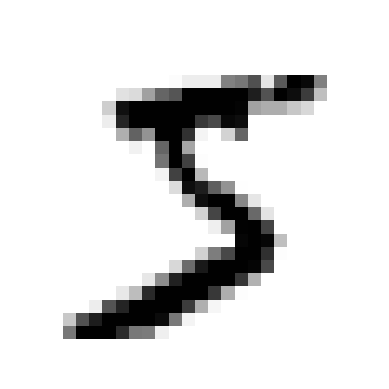

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
some_digit = X[0]
plot_digit(some_digit)
plt.show()

### Train test split

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [10]:
y_train_5 = (y_train == 5)  #if using minst = fetch_openml('mnist_784', as_frame = False)
                            #then y_train_5 = (y_train == '5') 
                            #(in csv y train is int, in fetch_openml Y_train is str)

                            #transforming the digit classification problem into a yes/no problem → detecting digit 5
y_test_5 = (y_test == 5)    #True (1) → Image is digit 5 , False (0) → Image is not 5 
                            #This is perfect for training a binary classifier (“Is this a 5?”).


In [11]:
print(y_train[:10])      # Look at values
print(y_train.dtype)     # See if it's object (strings) or int

[5 0 4 1 9 2 1 3 1 4]
int64


#### stochastic gradient descent (SGD)

In [12]:
from sklearn.linear_model import SGDClassifier #stochastic gradient descent (SGD)

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

#SGD capable of handling very large datasets efficiently. This is in
#part because SGD deals with training instances independently, one at a time, which
#also makes SGD well suited for online learning

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

### using cross-validation 

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.dummy import DummyClassifier 
#classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5)

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print (any(dummy_clf.predict(X_train))) #any() checks if at least one value in the array is True
                                        #Since the dummy classifier always predicts False (not 5) it will return false
                                        #If somehow the classifier predicted even one True, then any() would return True.
    

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#the accuracy is 90% bucause only about 10% of the image are 5s
#so if fyou guess that an image is not a 5 you will be right about 90% of the time

array([0.90965, 0.90965, 0.90965])

### Confusion matrix

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm
# array ([[TN,FP
#          FN,TP]])

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [20]:
from sklearn.metrics import precision_score , recall_score

In [21]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### F1 score

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision/Recall trade-off

In [24]:
y_scores = sgd_clf.decision_function([some_digit]) #Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.
y_scores                                           #Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores
            

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) #The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result as the predict() method (i.e., True). Let’s raise the threshold
y_some_digit_pred 

array([ True])

In [26]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #this confirms that rasing the threshold decreases recall. 
                  #the image represents a 5 and the classifier detects it when the threshold is -
                  #it misses it when the threshol is increased to 3000

array([False])

#### How to decide which threshold to use

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

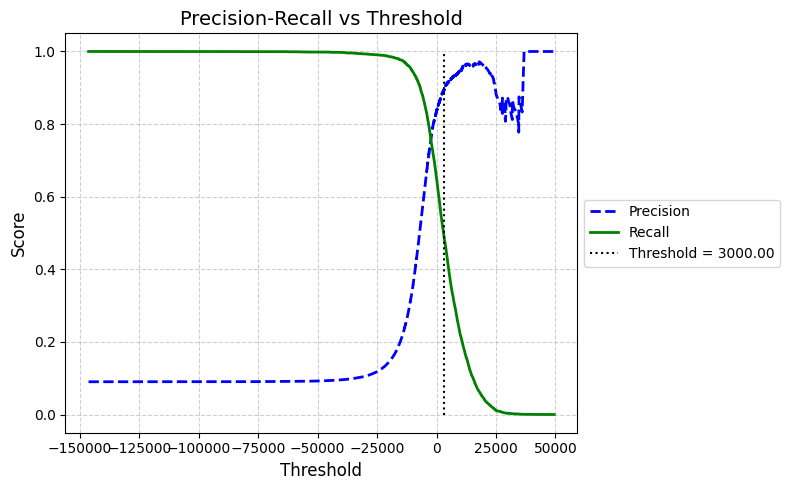

In [29]:
plt.figure(figsize=(8, 5))

# Plot Precision and Recall
plt.plot(thresholds, precisions[:-1], "b--", linewidth=2, label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", linewidth=2, label="Recall")

# Plot chosen threshold line
plt.vlines(threshold, 0, 1.0, colors="k", linestyles="dotted", label=f"Threshold = {threshold:.2f}")

# Labels and title
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision-Recall vs Threshold", fontsize=14)

# Legend outside the graph (to the right)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


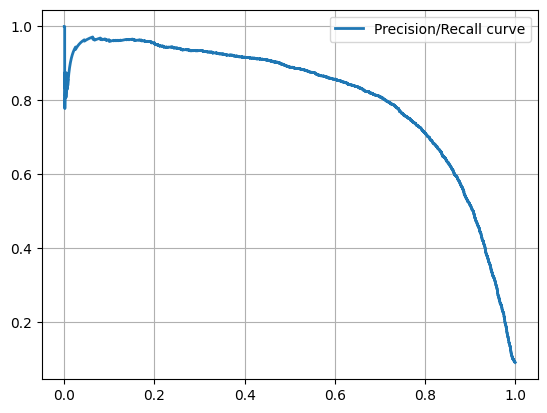

In [30]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.legend()  
plt.grid(True)
plt.show()

In [31]:
idx_for_90_precision = (precisions >= 0.90).argmax() #trying to finding the threshold at which precision first reaches (or exceeds) 90%.
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [32]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision) #make predicions on training set insead of calling the classiifiers predict() method
                                                           #If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”
                                                           #48% recall is not go for many applicaions

### ROC Curve

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

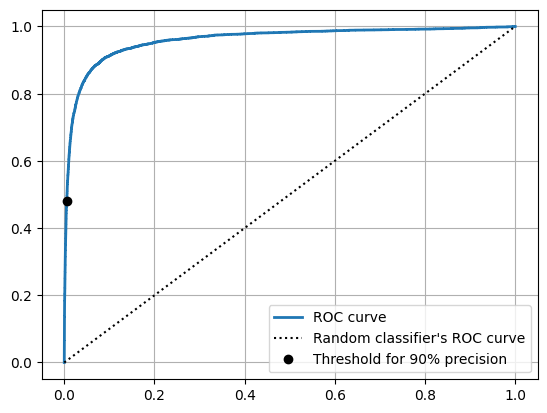

In [34]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend()  
plt.grid(True)
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score (y_train_5, y_scores)

np.float64(0.9604938554008616)

### Random forest

##### Explination of next code 
 here we training a Random Forest classifier on a binary classification task (is the digit a 5 or not). Instead of just predicting class labels, you get probability scores for each sample using cross-validation. Then, you use these scores to compute a precision–recall curve, which helps you analyze how precision and recall trade off at different thresholds.

#### Import and create the model

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

#### Cross-validated predictions with probabilities

In [37]:
#using the predict_proba() method to ruturns class probabilities for each instance 
#as the random forest class does not have decision_function()

y_probas_forest = cross_val_predict(forest_clf, X_train ,y_train_5, cv = 3, method = "predict_proba") #call the cross _val_predict() function to train the random forestClassifier 
                                                                                                      #using cross-validtion nad predict class probabilities for every image


###### 
y_probas_forest is a NumPy array of shape (n_samples, 2), and each row contain where first element is the probability that the sample belongs to class 0 (which is the ngative class, i.e. not 5), and the second element is the  probability that the sample belongs to class 1 (which is the positive class, i.e. is a 5)
so It’s probability of each class, where class 0 = negative, class 1 = positive.

In [38]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [39]:
y_probas_forest[:2] #looks for the probailities for the first two images in the training dataset

array([[0.11, 0.89],
       [0.99, 0.01]])

#### Extract probabilities for the positive class

In [40]:
y_scores_froset = y_probas_forest[:,1] #[:, 1] → take the second column from every row.
y_scores_froset  #the model’s confidence (predicted probability) that each training image is a “5.”

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

##### 
[:, 1] means output second element on each raw 
i.e. take the second column from every row.
So y_scores_froset becomes a 1D array of all the class 1 probabilities (the “is a 5” probabilities).
y_scores_froset is simply the array of probabilities for class 1 across all samples

#### Compute precision, recall, thresholds

In [41]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_froset)


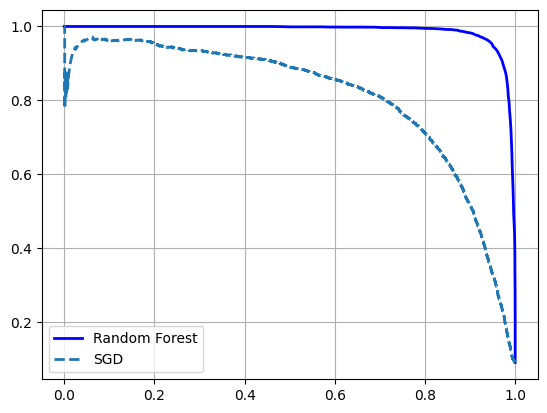

In [42]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.legend()  
plt.grid(True)
plt.show()

##### explination of the graph
 
x-axis → Recall (how many actual positives you correctly identified).
y-axis → Precision (how many predicted positives were actually correct).
Each curve shows how precision and recall change when you vary the decision threshold.

Random Forest (purple solid line):
Precision stays very close to 1.0 across almost the entire recall range.
This means Random Forest makes very accurate positive predictions and rarely misclassifies negatives as positives.
Even when you increase recall, precision doesn’t drop much until recall is extremely high.
That’s an excellent performance — Random Forest is clearly dominating

SGD (blue dashed line):
Precision starts high, but drops steadily as recall increases.
By the time recall is above ~0.7, precision has fallen below 0.8, and eventually crashes near 0.2 when recall is almost 1.
This shows SGD struggles with the precision–recall tradeoff compared to Random Forest.

Big Picture:
The higher and more to the right a PR curve is, the better the model.
Here, Random Forest’s curve almost hugs the top edge of the graph → it’s performing way better than SGD for this task.
This suggests Random Forest is much more reliable when identifying the positive class (“5” in MNIST).

Random Forest → nearly perfect precision until recall gets extremely high.
SGD → precision–recall tradeoff is much weaker.


##### Scores

In [43]:
y_train_pred_forest = y_probas_forest[:,1] >=0.5 #the predicted class labels (as True/False) for the training set, using a threshold of 0.5.
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [44]:
y_scores_forest = y_probas_forest[:, 1]
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

### Multiclass Classification

In [45]:
from sklearn.svm import SVC

svm_clf = SVC(random_state =42)
svm_clf.fit(X_train[:2000], y_train[:2000] ) #train model on first 2000 images

#trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5).

SVC(random_state=42)

##### One-versus-one or one-versus-the-rest detection
Scikit-Learn detects when you try to use a binary classification algorithm for a
multiclass classification task, and it automatically runs OvR or OvO, depending
on the algorithm. Let’s try this with a support vector machine classifier using the
sklearn.svm.

#### makes predection on an image

In [46]:
svm_clf.predict([some_digit])

array([5])

In [47]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2) #output the prediction  scores of all 10 classes

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [48]:
class_id = some_digit_scores.argmax() #output the class of the highst score 
class_id

np.int64(5)

In [49]:
#When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
svm_clf.classes_[class_id]

np.int64(5)

##### if you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneRestClassifier classes.

#### OneVsRestClassifier

In [51]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier (SVC (random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000] )

OneVsRestClassifier(estimator=SVC(random_state=42))

In [52]:
ovr_clf.predict([some_digit])

array([5])

In [53]:
len(ovr_clf.estimators_)

10

#### SGDClassifier with multicalss

In [54]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)


SGDClassifier(random_state=42)

In [55]:
sgd_clf.predict([some_digit]) #the prediction is incorrect

array([3])

In [56]:
sgd_clf.decision_function([some_digit]).round() #note that most of scores are ngative while class 3 has +ve score of 1824

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3 , scoring="accuracy") #the sgd gets over 85.8% on all test folds so it is not bad

array([0.87365, 0.85835, 0.8689 ])

#### Scaling data

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

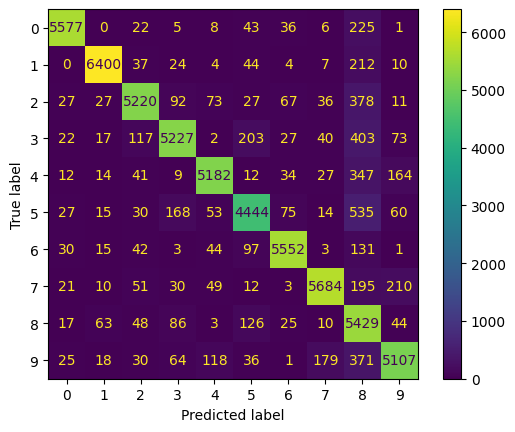

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

#shows the accuracy of prediction across all different classes right?

##### Notice that
The cell on the diagonal in row #5 and column #5 looks slightly
darker than the other digits. This could be because the model made more errors
on 5s, or because there are fewer 5s in the dataset than the other digits. That’s why
it’s important to normalize the confusion matrix by dividing each value by the total
number of images in the corresponding (true) class (i.e., divide by the row’s sum).

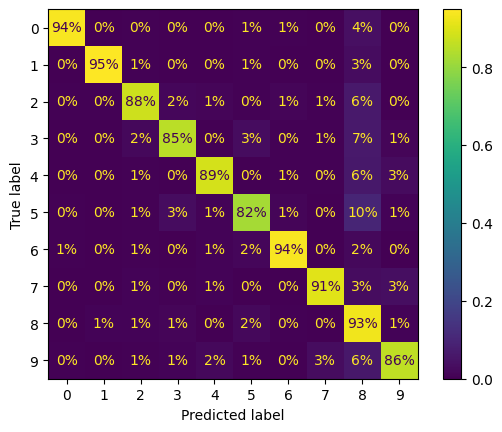

In [60]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()
#output matrix shows how many times each true class was predicted as each class
#i.e. This shows the distribution of predictions vs true labels (confusion matrix)

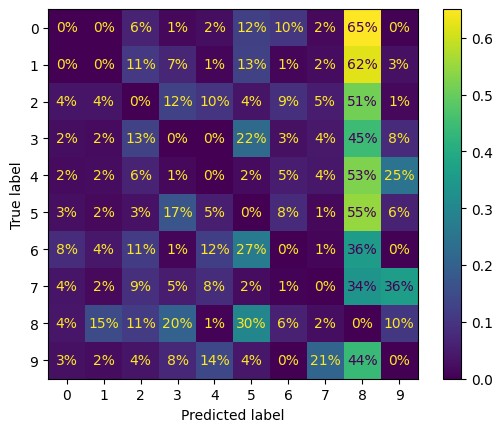

In [61]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight= sample_weight, normalize="true", values_format=".0%")
plt.show()
#A normalized confusion matrix of only the errors
#Each row = a true class (e.g., all actual 5’s).
#Each column = where those errors went (e.g., how often 5’s were mistaken for 3’s, 8’s, etc.).
#Because correct predictions were downweighted to 0, the diagonal is blank/zero.

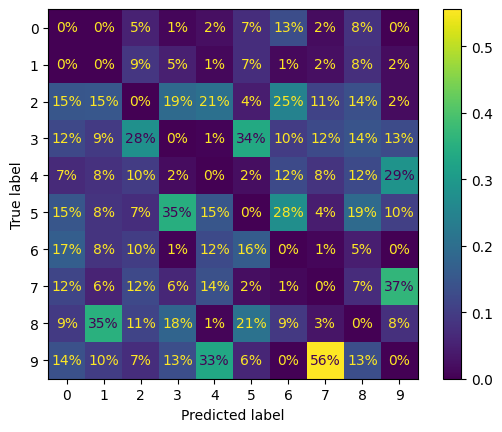

In [62]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight= sample_weight, normalize="pred", values_format=".0%")
plt.show()
#normalize the confusion matrix

### Multilabel Classification

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
y_train_large = (y_train >= 7) #True if the digit is ≥ 7 (i.e., 7, 8, 9).
y_train_odd = (y_train.astype('int8') % 2 == 1 ) #True if the digit is odd (1, 3, 5, 7, 9).


In [65]:
y_multilabel = np.c_[y_train_large, y_train_odd] #concatenates arrays column-wise. y_multilabel is a 2D array, shape (n_samples, 2).
knn_clf = KNeighborsClassifier ()
knn_clf.fit (X_train,y_multilabel)

KNeighborsClassifier()

In [66]:
knn_clf.predict([some_digit]) #predicted large = True, odd = False.

array([[False,  True]])

In [67]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train,y_multilabel,cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") 

0.9764102655606048

In [68]:
from sklearn.multioutput import ClassifierChain

In [69]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [70]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### Multioutput Classification

In [71]:
np.random.seed(42) #to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

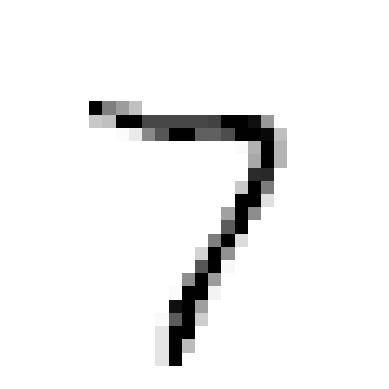

In [72]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()